# Preliminary Analysis 

In [74]:
# In this notebook, we will load the data and perform preliminary analysis

In [75]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [76]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot/order_datetime=2021-02-28/part-00001-cfff5211-ef46-4b99-a6ed-63c9b2c7fe15.c000.snappy.parquet')
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# Pre Process the tags column in tbl_merchants

In [77]:
merchants = merchants_tbl.toPandas()

In [78]:
import re
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [79]:
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [80]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [ ]:
# This could be further expanded in breaking the discription up further

# continue as usual from here

In [81]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [82]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [83]:
full_dataset.createOrReplaceTempView('las')
agg_data = spark.sql("""
select company_name, sum(dollar_value) from las
group by company_name""")

In [84]:
agg_data.count()

1922

In [85]:
# sketch
agg_data = agg_data.toPandas()

<AxesSubplot:xlabel='sum(dollar_value)', ylabel='Count'>

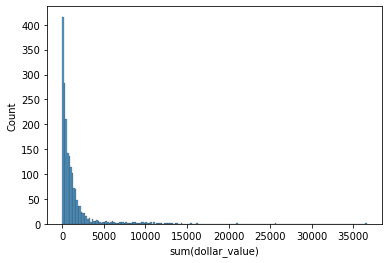

In [86]:
import seaborn as sns
sns.histplot(x = 'sum(dollar_value)', data=agg_data)

# Beaker line 